In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import nn, optim

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.utils.data import DataLoader, TensorDataset

# Classifier definition

In [2]:
class ClassifierNet(torch.nn.Module):

    def __init__(self):
        super(ClassifierNet, self).__init__()

        self.hidden0 = nn.Sequential(
            nn.Linear(2, 30),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(30, 100),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(100, 250),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(250, 500),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )
        self.hidden4 = nn.Sequential(
            nn.Linear(500, 250),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )
        self.hidden5 = nn.Sequential(
            nn.Linear(250, 100),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )
        self.hidden6 = nn.Sequential(
            nn.Linear(100, 30),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(30, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.hidden6(x)
        x = self.out(x)
        return x

# Target distribution

In [3]:
theta_true = 0.
true_dist = Normal(theta_true, 1.)

# Classifier instance: load persisted one or train a new one

In [4]:
def train_s(optimizer, s, x, y):
    optimizer.zero_grad()

    y_hat = s(x)
    error = loss(y_hat, y)
    error.backward()
    optimizer.step()

    return error, y_hat

try:
    #persisted one trained for 400 epochs
    #on n_thetas, x_per_theta = 1000, 1000
    s = torch.load("classifier.dat")
except FileNotFoundError:
    #training data
    U = Uniform(-10., 10.)

    n_thetas = 10000
    x_per_theta = 10000
    training_set_size = n_thetas * x_per_theta
    X = torch.empty(training_set_size, 2)
    Y = torch.empty(training_set_size, 1)

    for i in range(0, n_thetas):

        theta = U.sample().item()

        for j in range(0, x_per_theta, 2):

            x = Normal(theta, 1.).sample().item()

            X[i*x_per_theta+j] = torch.tensor([theta, x])
            Y[i*x_per_theta+j] = 1.

            x_fake = true_dist.sample().item()

            X[i*x_per_theta+j+1] = torch.tensor([theta, x_fake])
            Y[i*x_per_theta+j+1] = 0.

    dataset = TensorDataset(X, Y)
    data_loader = DataLoader(dataset, batch_size=100, shuffle=False)

    #train a net
    s = ClassifierNet()
    optimizer = optim.Adam(s.parameters(), lr=0.0002)

    num_epochs = 3000

    for epoch in range(num_epochs):
        print("Epoch {} of {}".format(epoch+1, num_epochs))
        for n_batch, batch in enumerate(data_loader):
            x = batch[0]
            y = batch[1]
            error, y_hat = train_s(optimizer, s, x, y)

    torch.save(s, "classifier.dat")

/Users/vladimirbegy/anaconda3/lib/python3.6/site-packages/torch/serialization.py:391: UserWarning: Couldn't retrieve source code for container of type ClassifierNet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


# Analytical LR vs. Classifier LR

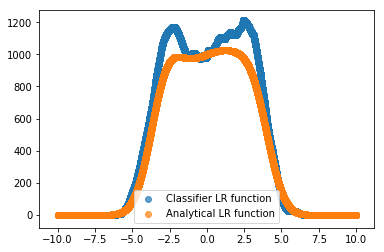

In [5]:
n_obs = 1000
true_obs = true_dist.sample(torch.Size([n_obs])).view(-1, 1)

def analytical_lr(theta, observations):
    p_true = Normal(0., 1.)
    p_other = Normal(theta, 1.)

    return (p_other.log_prob(observations).exp() / p_true.log_prob(observations).exp()).sum()

def classifier_lr(theta, observations, s):
    input = theta.view(-1, 1).repeat(n_obs, 1)
    input = torch.cat((input, observations), 1)
    _s = s(input)
    lr = (_s) / (1 - _s)
    return lr.sum()

min_x = np.amin(-10.)
max_x = np.amax(10.)
thetas_range = np.linspace(float(min_x), float(max_x), 30000)

a_lr = []
c_lr = []
for theta in thetas_range:
    a_lr.append(analytical_lr(theta, true_obs).item())
    c_lr.append(classifier_lr(torch.tensor([theta]), true_obs, s).item())

plt.scatter(thetas_range, c_lr, alpha=.7, label="Classifier LR function")
plt.scatter(thetas_range, a_lr, alpha=.7, label="Analytical LR function")
plt.legend()
plt.show()

# Likelihood free inference with Metropolis Hastings

In [6]:
theta_current = torch.tensor([5.0])
steps = 1000
thetas = []

n_obs = 1000
true_obs = true_dist.sample(torch.Size([n_obs])).view(-1, 1)

for i in range(steps):
    #print("Iteration {} of {}".format(i+1, steps))

    proposal = Normal(theta_current, torch.tensor([1.0]))
    theta_next = proposal.sample()

    input_current = theta_current.view(-1, 1).repeat(n_obs, 1)
    input_current = torch.cat((input_current, true_obs), 1)
    s_current = s(input_current)
    lr_current = (s_current) / (1 - s_current)

    input_next = theta_next.view(-1, 1).repeat(n_obs, 1)
    input_next = torch.cat((input_next, true_obs), 1)
    s_next = s(input_next)
    lr_next = (s_next) / (1 - s_next)

    lr = (lr_next.log().sum() - lr_current.log().sum()).exp()
    acceptance = min(1, lr.item())

    if np.random.uniform() <= acceptance:
        theta_current = theta_next
        #print("ACCEPTED new theta: {}".format(theta_current.item()))

    thetas.append(theta_current.item())
    
mean_theta = sum(thetas) / float(len(thetas))
print("Mean of estimated thetas: {}".format(mean_theta))

Mean of estimated thetas: 0.11988148095458746


# Likelihood free inference with Hamiltonian MC

In [7]:
theta_current = torch.tensor([5.0])
steps = 1000
thetas = []

n_obs = 1000
true_obs = true_dist.sample(torch.Size([n_obs])).view(-1, 1)

def ref_likelihood(observations):
    return Normal(0., 1.).log_prob(observations).exp()

def U(theta, observations, s):
    input = theta.view(-1, 1).repeat(n_obs, 1)
    input = torch.cat((input, observations), 1)
    _s = s(input)
    lr = (_s) / (1 - _s)
    likelihood = lr * ref_likelihood(observations)
    return -likelihood.log().sum()

def dU(theta, observations, s):
    theta_var = torch.autograd.Variable(theta, requires_grad=True)
    out = U(theta_var, observations, s)
    out.backward()
    gradient = theta_var.grad
    theta_var.detach()
    return gradient

def K(momentum):
    return ((momentum * momentum) / 2).sum()

def dK(momentum):
    momentum_var = torch.autograd.Variable(momentum, requires_grad=True)
    out = K(momentum_var)
    out.backward()
    gradient = momentum_var.grad
    momentum_var.detach()
    return gradient

momentum_dist = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
leapfrog_steps = 30
leapfrog_stepsize = 0.0005

for i in range(steps):
    #print("Iteration {} of {}".format(i+1, steps))

    momentum = momentum_dist.rsample()

    momentum_next = momentum
    theta_next = theta_current

    for j in range(leapfrog_steps):
        momentum_next = momentum_next - (leapfrog_stepsize / 2) * dU(theta_next, true_obs, s)
        theta_next = theta_next + leapfrog_stepsize * dK(momentum_next)
        momentum_next = momentum_next - (leapfrog_stepsize / 2) * dU(theta_next, true_obs, s)

    rho = (U(theta_current, true_obs, s) - U(theta_next, true_obs, s)) - \
          K(momentum_next) + K(momentum)

    rho = rho.exp()
    u = np.random.uniform()
    a = min([1, rho])

    #print("Current: {}".format(theta_current.item()))
    #print("Next: {}".format(theta_next.item()))
    #print("Rho: {}".format(rho))

    if u <= a:
        theta_current = theta_next
        #print("ACCEPTED")
    #print("####################\n")

    thetas.append(theta_current.item())

mean_theta = sum(thetas) / float(len(thetas))
print("Mean of estimated thetas: {}".format(mean_theta))

Mean of estimated thetas: 0.10418816389702261
